## Data Preprocessing

In [1]:
# Download packages if necessary:

#!pip install kmodes
#!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import compress
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [3]:
movies_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

In [4]:
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

From now on, we work with the columns that contain useful tabular information.  
We remove `budget, revenue and popularity` due to high prevalence of missing values.

In [5]:
movies_metadata = movies_metadata.loc[:,[
    'title', 'adult', 'genres', 'id', 'original_language',
    'production_companies', 'production_countries', 'release_date',
    'runtime', 'spoken_languages', 'status', 'vote_average', 'vote_count'
]].set_index('id')

In [6]:
def zero_to_nan(value):
    try:
        if float(value) < 1 and float(value) > -1:
            return np.NaN
        else:
            return value
    except ValueError:
        print(value)
        return np.NaN

In [7]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0
8844,Jumanji,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0
31357,Waiting to Exhale,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0
11862,Father of the Bride Part II,False,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0


In [8]:
movies_metadata['runtime'] = movies_metadata['runtime'].apply(zero_to_nan)
print("1")
movies_metadata['vote_average'] = movies_metadata['vote_average'].apply(zero_to_nan)

1


In [9]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0
8844,Jumanji,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0
31357,Waiting to Exhale,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0
11862,Father of the Bride Part II,False,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0


In [10]:
movies_metadata.loc["461257",:].genres

'[]'

In [11]:
unpackable_cols = ('genres', 'production_companies', 'production_countries',
                   'spoken_languages')

for col in unpackable_cols:
    movies_metadata[col] = movies_metadata[col].apply(lambda x: np.NaN if x == '[]' else x)    

In [12]:
main_keys = {
    'genres':'name',
    'production_companies':'id',
    'production_countries':'iso_3166_1',
    'spoken_languages':'iso_639_1'
}

def unpack_list_of_dicts(value_list:str,        # organized like List[Dict[str, Any]]
                         main_key:str) -> set:
    out = []
    
    if not isinstance(value_list, str):
        return np.NaN

    clean_value_list = value_list[2:-2].replace(", {", "").split("}")

    for val in clean_value_list:
        sep_val = val.split(', ')
        main_key_mask = [main_key in e for e in sep_val]
        try:
            main_component = list(compress(sep_val, main_key_mask))[0]
        except IndexError:  # Weird cases with wrong typing
            return np.NaN
        clean_component = main_component.split(': ')[1].replace("'","")
        out.append(clean_component)
    return out 


for col in unpackable_cols:
    key = main_keys[col]  
    movies_metadata[col].apply(lambda x: unpack_list_of_dicts(x, main_key=key))

In [13]:
for col in unpackable_cols:
    key = main_keys[col]
    movies_metadata[col] = movies_metadata[col].apply(lambda x: unpack_list_of_dicts(x, main_key=key))

In [14]:
movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,81.0,[en],Released,7.7,5415.0
8844,Jumanji,False,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,104.0,"[en, fr]",Released,6.9,2413.0
15602,Grumpier Old Men,False,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,101.0,[en],Released,6.5,92.0
31357,Waiting to Exhale,False,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,127.0,[en],Released,6.1,34.0
11862,Father of the Bride Part II,False,[Comedy],en,"[5842, 9195]",[US],1995-02-10,106.0,[en],Released,5.7,173.0


Finally, for preprocessing, we scale the numerical variables to mitigate the influence of differently-scaled variables on the clustering.

In [15]:
scaler = MinMaxScaler()

movies_metadata[['runtime', 'vote_average', 'vote_count']] = scaler.fit_transform(movies_metadata[['runtime', 'vote_average', 'vote_count']])

movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,False,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,0.063745,[en],Released,0.744444,0.384725
8844,Jumanji,False,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,0.082072,"[en, fr]",Released,0.655556,0.171439
15602,Grumpier Old Men,False,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,0.079681,[en],Released,0.611111,0.006536
31357,Waiting to Exhale,False,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,0.100398,[en],Released,0.566667,0.002416
11862,Father of the Bride Part II,False,[Comedy],en,"[5842, 9195]",[US],1995-02-10,0.083665,[en],Released,0.522222,0.012291


Due to limitations in the existing K-Prototypes implementation, we drop rows that contain NaNs.

In [16]:
movies_metadata.shape

(45466, 12)

In [17]:
movies_metadata['adult'] = movies_metadata.adult.apply(lambda x: 0 if x == "False" else 1)

In [18]:
analysis_columns = list(movies_metadata.columns)
analysis_columns.remove('title')
analysis_columns.remove('release_date')

analysis_columns

['adult',
 'genres',
 'original_language',
 'production_companies',
 'production_countries',
 'runtime',
 'spoken_languages',
 'status',
 'vote_average',
 'vote_count']

In [19]:
movies_metadata.dropna(inplace=True, subset=analysis_columns)
movies_metadata.shape

(30575, 12)

[ADD SAMPLING BASED ON SOME DATE FORWARDS, OR SOME TOP-SELLING, OR BY ORIGIN]

In [20]:
movies_metadata['release_date'] = pd.to_datetime(movies_metadata.release_date)

movies_metadata.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,,,
862,Toy Story,0,"[Animation, Comedy, Family]",en,[3],[US],1995-10-30,0.063745,[en],Released,0.744444,0.384725
8844,Jumanji,0,"[Adventure, Fantasy, Family]",en,"[559, 2550, 10201]",[US],1995-12-15,0.082072,"[en, fr]",Released,0.655556,0.171439
15602,Grumpier Old Men,0,"[Romance, Comedy]",en,"[6194, 19464]",[US],1995-12-22,0.079681,[en],Released,0.611111,0.006536
31357,Waiting to Exhale,0,"[Comedy, Drama, Romance]",en,[306],[US],1995-12-22,0.100398,[en],Released,0.566667,0.002416
11862,Father of the Bride Part II,0,[Comedy],en,"[5842, 9195]",[US],1995-02-10,0.083665,[en],Released,0.522222,0.012291


Having to sample a subset for performance reasons, we first limit to 2000's movies to increase relevance and apparent similarity:

In [21]:
movies_metadata = movies_metadata[movies_metadata.release_date > '2000-01-01']

movies_metadata.shape

(15227, 12)

In [22]:
# We subsample to limit dataset size
movies_metadata.reset_index(drop=True, inplace=True)
movies_metadata = movies_metadata.sample(8000, random_state=42)

# Alternative Analyses

## Option 1: Treat any multi-valued categorical attribute value as a single value

This first option treats any multi-valued categorical variable as if they were single-valued categorical variables. This means that each attribute can have up to $\sum_{k=1}^{|L|} {{|L| \choose k}}$ possible levels. Models will treat each level orthogonally, even though they may contain values of the vocabulary $L$ in common.

In [21]:
option_1_df = movies_metadata.copy()

In [22]:
for col in unpackable_cols:
    option_1_df[col] = option_1_df[col].astype(str)

In [23]:
option_1_df.dtypes

title                    object
adult                     int64
genres                   object
original_language        object
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count              float64
dtype: object

In [24]:
X = option_1_df.loc[:,analysis_columns]
X

,adult,genres,original_language,production_companies,production_countries,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,
83849,0,"['Drama', 'TV Movie']",en,"['9223', '18314']",['US'],0.072510,['en'],Released,0.755556,0.000142
109251,0,"['Drama', 'Romance']",en,['33'],['US'],0.076494,['en'],Released,0.555556,0.000071
17819,0,"['Comedy', 'Crime', 'Mystery', 'Romance']",en,['6194'],['US'],0.074104,"['en', 'ro', 'es']",Released,0.444444,0.002629
11296,0,"['Drama', 'History']",en,['559'],['US'],0.094821,['en'],Released,0.655556,0.007957
129535,0,"['Comedy', 'Music', 'Romance']",en,['6'],['US'],0.060558,['en'],Released,0.611111,0.000071
...,...,...,...,...,...,...,...,...,...,...
16877,0,"['Thriller', 'Mystery', 'Adventure']",en,['3324'],['GB'],0.070916,"['de', 'en']",Released,0.488889,0.000639
172535,0,"['History', 'Drama']",en,"['1807', '34758']",['GB'],0.102789,['en'],Released,0.588889,0.000497
20178,0,"['Comedy', 'Romance']",en,"['1030', '7357']",['US'],0.078088,['en'],Released,0.611111,0.012860


In [25]:
# cat_cols = ['adult', 'genres', 'original_language', 'production_companies', 'production_countries', 'spoken_languages', 'status']
cat_cols = [0, 1, 2, 3, 4, 6, 7]

Due to limitations in the existing K-Prototypes implementation, we drop rows that contain NaNs.

In [26]:
kp = KPrototypes(n_clusters=4, verbose=True, init='Cao', random_state=42)
labels = kp.fit_predict(X, categorical=cat_cols)

Initialization method and algorithm are deterministic. Setting n_init to 1.


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3065, ncost: 1068.0128598372594
Run: 1, iteration: 2/100, moves: 1248, ncost: 1064.3907689512491
Run: 1, iteration: 3/100, moves: 530, ncost: 1063.7788938531487
Run: 1, iteration: 4/100, moves: 106, ncost: 1063.7657562026943
Run: 1, iteration: 5/100, moves: 16, ncost: 1063.7656167558928
Run: 1, iteration: 6/100, moves: 2, ncost: 1063.7656161802747
Run: 1, iteration: 7/100, moves: 0, ncost: 1063.7656161802747
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2686, ncost: 1099.3348244012989
Run: 2, iteration: 2/100, moves: 2044, ncost: 1049.1239157296632
Run: 2, iteration: 3/100, moves: 1123, ncost: 1047.3201461410135
Run: 2, iteration: 4/100, moves: 279, ncost: 1047.086668507793
Run: 2, iteration: 5/100, moves: 12, ncost: 1047.0861950022752
Run: 2, iteration: 6/100, moves: 0, ncost: 1047.0861950022752
Init: initia

In [27]:
print(kp.cluster_centroids_)

[['0.07918272691061641' '0.6096725222294509' '0.01708596286661775' '0'
  "['Drama']" 'en' "['8411']" "['US']" "['en']" 'Released']
 ['0.08007346696403297' '0.5800693240901215' '0.0029119196185327725' '0'
  "['Comedy']" 'fr' "['5542']" "['FR']" "['fr']" 'Released']
 ['0.08367113556356585' '0.6855967078189328' '0.013624103677389608' '0'
  "['Drama', 'Romance']" 'en' "['6194']" "['GB']" "['en']" 'Released']
 ['0.07443600551887136' '0.4056881707267346' '0.004448364011848271' '0'
  "['Comedy']" 'en' "['4']" "['US']" "['en']" 'Released']]


In [28]:
print(kp.cluster_centroids_[0])

['0.07918272691061641' '0.6096725222294509' '0.01708596286661775' '0'
 "['Drama']" 'en' "['8411']" "['US']" "['en']" 'Released']


If we look at the cluster membership of the first cluster...

In [29]:
X[kp.labels_ == 0]

,adult,genres,original_language,production_companies,production_countries,runtime,spoken_languages,status,vote_average,vote_count
id,,,,,,,,,,
83849,0,"['Drama', 'TV Movie']",en,"['9223', '18314']",['US'],0.072510,['en'],Released,0.755556,0.000142
109251,0,"['Drama', 'Romance']",en,['33'],['US'],0.076494,['en'],Released,0.555556,0.000071
11296,0,"['Drama', 'History']",en,['559'],['US'],0.094821,['en'],Released,0.655556,0.007957
129535,0,"['Comedy', 'Music', 'Romance']",en,['6'],['US'],0.060558,['en'],Released,0.611111,0.000071
2163,0,"['Drama', 'Action', 'Thriller']",en,"['4', '10308', '10355']",['US'],0.074900,['en'],Released,0.622222,0.014352
...,...,...,...,...,...,...,...,...,...,...
20025,0,"['Drama', 'Thriller']",en,['306'],['US'],0.074104,"['en', 'it']",Released,0.677778,0.001421
22390,0,"['Comedy', 'Western']",en,['4'],['US'],0.070916,['en'],Released,0.688889,0.000924
20178,0,"['Comedy', 'Romance']",en,"['1030', '7357']",['US'],0.078088,['en'],Released,0.611111,0.012860


We can see, as expected, that the genres and the production companies have *nothing in common* with the centroid! Concordance is higher for the status, adult and genre attributes, which can be attributed to the higher frequency of the values taken in the centroids.

In [30]:
# We add cluster membership to the original dataframe to keep track.

movies_metadata['membership_1'] = kp.labels_

Every run took about 6 to 16 iterations to converge. To judge the quality of the clustering, we can use the Silhouette score.

Since the distance is a linear combination, we can compute the numeric distance matrix, then the categorical one, and sum them taking advantage of numpy's speed.

In [31]:
num_cols = [i for i in range(len(X.columns)) if i not in cat_cols]

In [32]:
for col_i in cat_cols:
    X.iloc[:,col_i] = X.iloc[:,col_i].astype(str)

In [33]:
X_cat = X.iloc[:,cat_cols]
X_num = X.iloc[:,num_cols]

In [34]:
# K-Prototype uses the squared euclidean to avoid the square root operation

distance_matrix_num = pdist(X_num.values)

In [35]:
X_cat

,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
id,,,,,,,
83849,0,"['Drama', 'TV Movie']",en,"['9223', '18314']",['US'],['en'],Released
109251,0,"['Drama', 'Romance']",en,['33'],['US'],['en'],Released
17819,0,"['Comedy', 'Crime', 'Mystery', 'Romance']",en,['6194'],['US'],"['en', 'ro', 'es']",Released
11296,0,"['Drama', 'History']",en,['559'],['US'],['en'],Released
129535,0,"['Comedy', 'Music', 'Romance']",en,['6'],['US'],['en'],Released
...,...,...,...,...,...,...,...
16877,0,"['Thriller', 'Mystery', 'Adventure']",en,['3324'],['GB'],"['de', 'en']",Released
172535,0,"['History', 'Drama']",en,"['1807', '34758']",['GB'],['en'],Released
20178,0,"['Comedy', 'Romance']",en,"['1030', '7357']",['US'],['en'],Released


In [36]:
cat_encoders = dict()

for col in X_cat.columns:
    cat_enc = LabelEncoder()
    X_cat.loc[:,col] = cat_enc.fit_transform(X_cat.loc[:,col])

    cat_encoders[col] = cat_enc

C:\Users\manue\AppData\Local\Temp\ipykernel_19812\3294704791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat.loc[:,col] = cat_enc.fit_transform(X_cat.loc[:,col])
C:\Users\manue\AppData\Local\Temp\ipykernel_19812\3294704791.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_cat.loc[:,col] = cat_enc.fit_transform(X_cat.loc[:,col])


In [37]:
X_cat.head()

,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
id,,,,,,,
83849,0,1035,15,7339,897,441,3
109251,0,1024,15,3408,897,441,3
17819,0,585,15,5765,897,408,3
11296,0,964,15,5328,897,441,3
129535,0,690,15,5555,897,441,3


In [38]:
distance_matrix_cat = pdist(X_cat, 'hamming')

In [39]:
distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [40]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,-0.284675,0
1,-0.061774,0
2,0.438058,3
3,0.015463,0
4,0.137237,0


<AxesSubplot:xlabel='silhouette_values', ylabel='Count'>

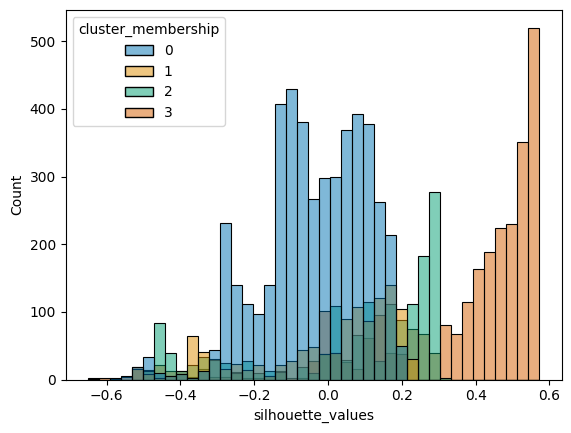

In [41]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [42]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.08836254056576219


Having established the process, we can choose an optimal K based on the silhouette scores, and judge each approach based on its optimal cluster arrangement. **Whether the output clusterings are any good**, however, is to be judged *a posteriori*.

In [43]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(X, categorical=cat_cols)
    
    score=silhouette_score(distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1786, ncost: 1112.209715474323
Run: 1, iteration: 2/100, moves: 772, ncost: 1108.9821365862124
Run: 1, iteration: 3/100, moves: 306, ncost: 1108.5754642568827
Run: 1, iteration: 4/100, moves: 237, ncost: 1108.2401801329233
Run: 1, iteration: 5/100, moves: 96, ncost: 1108.2029539090295
Run: 1, iteration: 6/100, moves: 0, ncost: 1108.2029539090295
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 701, ncost: 1167.357495228735
Run: 2, iteration: 2/100, moves: 9, ncost: 1167.357482514028
Run: 2, iteration: 3/100, moves: 0, ncost: 1167.357482514028
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 580, ncost: 1154.8270023494106
Run: 3, iteration: 2/100, moves: 11, ncost: 1154.82634

In [44]:
scores_dict

{'2': 0.4138094141670511,
 '3': 0.12466289970287364,
 '4': 0.08836254056576219,
 '5': 0.11624103982650877,
 '6': 0.014015900524652927,
 '7': 0.1035695712263949,
 '8': 0.07108022778310283,
 '9': 0.06506825951962293}

Higher is better (Rousseeuw, 1986), so we settle for two clusters. 

In [45]:
kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
labels = kp.fit_predict(X, categorical=cat_cols)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1786, ncost: 1112.209715474323
Run: 1, iteration: 2/100, moves: 772, ncost: 1108.9821365862124
Run: 1, iteration: 3/100, moves: 306, ncost: 1108.5754642568827
Run: 1, iteration: 4/100, moves: 237, ncost: 1108.2401801329233
Run: 1, iteration: 5/100, moves: 96, ncost: 1108.2029539090295
Run: 1, iteration: 6/100, moves: 0, ncost: 1108.2029539090295
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 701, ncost: 1167.357495228735
Run: 2, iteration: 2/100, moves: 9, ncost: 1167.357482514028
Run: 2, iteration: 3/100, moves: 0, ncost: 1167.357482514028
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 580, ncost: 1154.8270023494106
Run: 3, iteration: 2/100, moves: 11, ncost: 1154.82634

In [46]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.548803,0
1,0.154609,0
2,0.570396,1
3,0.599925,0
4,0.502222,0


<AxesSubplot:xlabel='silhouette_values', ylabel='Count'>

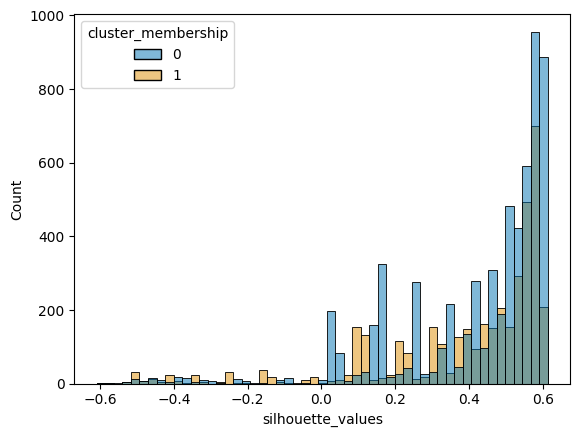

In [47]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [48]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.4138094141670511


Some points in the left tail seem to indicate undesirable clustering, but the general concentration of points in the right indicates that the clusters are differentiated to an agreeable degree.

In [49]:
centroid_df = pd.DataFrame(kp.cluster_centroids_, columns = list(X_num.columns)+list(X_cat.columns))

In [50]:
centroid_df.loc[:,X_num.columns] = scaler.inverse_transform(centroid_df[X_num.columns])

In [51]:
centroid_df

,runtime,vote_average,vote_count,adult,genres,original_language,production_companies,production_countries,spoken_languages,status
0,102.41506,6.762284,214.18458,0,['Drama'],en,['8411'],['US'],['en'],Released
1,95.498711,4.950619,78.742651,0,['Comedy'],en,['6194'],['US'],['en'],Released


In [52]:
X.groupby('genres').count()['adult'].sort_values(ascending=False).head()

genres
['Drama']               1172
['Comedy']               776
['Drama', 'Romance']     324
['Documentary']          290
['Comedy', 'Drama']      274
Name: adult, dtype: int64

In [53]:
X.groupby('original_language').count()['adult'].sort_values(ascending=False).head()

original_language
en    7080
fr     582
ja     292
it     257
de     240
Name: adult, dtype: int64

In [54]:
X.groupby('production_companies').count()['adult'].sort_values(ascending=False).head()

production_companies
['8411']    189
['4']       150
['6194']    145
['306']     141
['33']      107
Name: adult, dtype: int64

As expected, the most common categories dominate the cluster centroids with an utter disregard for the contents of the multi-valued categorical attributes.

## Option 2: Apply Multi-Label Binarization. One-hot-encoding across values of all multi-valued attributes.

We may create up to $\sum_{x=1}^{m}{|L|}$ new attributes in the process if all possible levels of the vocabulary are present. If a given clustering is to be re-used for unseen observations, practicioners should be mindful of previously unseen values of the attributes' vocabulary. If no sample containing the complete dictionaries can be assembled, clusters should be fit on the maximum amount of attributes, even if some are empty as a result.

In [37]:
option_2_df = movies_metadata.copy()

In [38]:
option_2_df.head()

,title,adult,genres,original_language,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count
8968,Black Venus,0,"[History, Drama]",fr,[83],"[FR, IT]",2010-10-27,0.125896,"[af, nl, en, fr]",Released,0.666667,0.002629
10795,Garam Masala,0,[Comedy],hi,[3939],[IN],2005-11-03,0.112351,[hi],Released,0.488889,0.001137
8239,Winter Nomads,0,[Documentary],fr,[6841],"[CH, FR, DE]",2012-02-10,0.070916,[fr],Released,0.777778,0.000213
14258,Lady Macbeth,0,[Drama],en,"[288, 7281, 64479, 74150, 92473, 92474]",[GB],2017-01-20,0.070120,[en],Released,0.633333,0.006323
14059,How to Draw a Perfect Circle,0,[Drama],pt,"[8680, 16418, 26019]",[PT],2009-09-23,0.073307,[pt],Released,0.477778,0.000497


In [39]:
option_2_df.index.rename('index', inplace=True)

### 2.1 Data Preparation

In [40]:
columns_to_concat = [option_2_df]
dummy_cols = []
multi_val_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

for attribute in multi_val_cols:
    dummy_df = pd.get_dummies(option_2_df[attribute].apply(pd.Series).stack()).groupby('index', level=0).sum()
    dummy_cols += list(dummy_df.columns)
    columns_to_concat.append(dummy_df)

In [41]:
option_2_df = pd.concat(columns_to_concat, axis=1).drop(multi_val_cols, axis=1)

option_2_df.shape

(8000, 10125)

In [42]:
option_2_df.shape

(8000, 10125)

This approach to clustering multi-valued categorical attributes generates an explosive amount of columns. Common practice involves dropping uncommon labels, at the cost of losing sensitivity to anomalies.

In [43]:
frequencies = pd.DataFrame(option_2_df[dummy_cols].mean(), columns=['freq']).sort_values('freq')

frequencies

,freq
4259,0.000125
54268,0.000125
54259,0.000125
54245,0.000125
54238,0.000125
...,...
Thriller,0.233250
Comedy,0.305750
Drama,0.494875
US,0.521250


In [44]:
frequencies[frequencies.freq >= 0.005]

,freq
HU,0.005000
ta,0.005125
43,0.005125
el,0.005125
14,0.005250
...,...
Thriller,0.233250
Comedy,0.305750
Drama,0.494875
US,0.521250


In [45]:
saved_dummies = list(frequencies[frequencies.freq >= 0.005].index)

saved_cols = ['title', 'adult', 'original_language', 'release_date', 'runtime', 'status', 'vote_average','vote_count'] + saved_dummies

88 rows labels with a frequency of at least 0.5% will be saved.

In [46]:
option_2_df = option_2_df.loc[:,saved_cols]

option_2_df.shape

(8000, 110)

In [47]:
attributes = ['adult', 'original_language', 'runtime', 'status', 'vote_average','vote_count'] + saved_dummies

X = option_2_df.loc[:, attributes]

X.head()

,adult,original_language,runtime,status,vote_average,vote_count,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
index,,,,,,,,,,,,,,,,,,,,,
8968,0,fr,0.125896,Released,0.666667,0.002629,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
10795,0,hi,0.112351,Released,0.488889,0.001137,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8239,0,fr,0.070916,Released,0.777778,0.000213,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
14258,0,en,0.070120,Released,0.633333,0.006323,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
14059,0,pt,0.073307,Released,0.477778,0.000497,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [48]:
cat_encoders = dict()
cat_cols = ['adult', 'original_language', 'status']

for col in X.columns:
    if col in cat_cols:
        cat_enc = LabelEncoder()
        X[col] = cat_enc.fit_transform(X.loc[:,col])

        cat_encoders[col] = cat_enc

### 2.2 Clustering

We start by using the silhouette technique to find an optimal k.

In [65]:
cat_col_indexes = [i for i in range(len(X.columns)) if X.columns[i] in (cat_cols + dummy_cols)]
num_col_indexes = list(
    set(cat_col_indexes).symmetric_difference(
        set(range(len(X.columns)))
        )
    )

In [71]:
# K-Prototype uses the squared euclidean to avoid the square root operation

distance_matrix_num = pdist(X.iloc[:, num_col_indexes].values)
distance_matrix_cat = pdist(X.iloc[:, cat_col_indexes].values, 'hamming')
distance_matrix = squareform(distance_matrix_cat*kp.gamma + distance_matrix_num)

In [72]:
scores_dict = dict()

for k in range(2, 6):
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=True, random_state=42)
    labels = kp.fit_predict(X, categorical=cat_col_indexes)
    
    score=silhouette_score(distance_matrix, labels, metric="precomputed")
    scores_dict[str(k)] = score

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2546, ncost: 1302.2586989865763
Run: 1, iteration: 2/100, moves: 335, ncost: 1302.1400419422916
Run: 1, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 1, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2439, ncost: 1302.3208285972446
Run: 2, iteration: 2/100, moves: 440, ncost: 1302.1400419422916
Run: 2, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 2, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2448, ncost: 1302.2956280537292
Run: 3, iteration: 2/100, moves: 433, ncost: 1302.1400419422916
Run: 3, iteration: 3/100, moves: 2, ncost: 1302.13988

In [73]:
scores_dict

{'2': 0.041903974132294304,
 '3': -0.08908649484634068,
 '4': -0.05268306368045357,
 '5': -0.08304994791691438,
 '6': -0.11893844437994613,
 '7': -0.11049730699545852,
 '8': -0.0931933278023038,
 '9': -0.08733717553357524}

The dimensionality leads to no good clustering solution existing.

In [75]:
kp = KPrototypes(n_clusters=2, init='Cao', verbose=True, random_state=42)
labels = kp.fit_predict(X, categorical=cat_col_indexes)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2546, ncost: 1302.2586989865763
Run: 1, iteration: 2/100, moves: 335, ncost: 1302.1400419422916
Run: 1, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 1, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2439, ncost: 1302.3208285972446
Run: 2, iteration: 2/100, moves: 440, ncost: 1302.1400419422916
Run: 2, iteration: 3/100, moves: 2, ncost: 1302.139885827999
Run: 2, iteration: 4/100, moves: 0, ncost: 1302.139885827999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2448, ncost: 1302.2956280537292
Run: 3, iteration: 2/100, moves: 433, ncost: 1302.1400419422916
Run: 3, iteration: 3/100, moves: 2, ncost: 1302.13988

### 2.3 Evaluation

In [76]:
silhouette_df = pd.DataFrame()

silhouette_df['silhouette_values'] = silhouette_samples(distance_matrix, kp.labels_ , metric="precomputed")
silhouette_df['cluster_membership'] = labels

silhouette_df.head()

,silhouette_values,cluster_membership
0,0.359602,1
1,-0.074028,1
2,0.286553,1
3,0.364772,1
4,-0.131227,1


<AxesSubplot:xlabel='silhouette_values', ylabel='Count'>

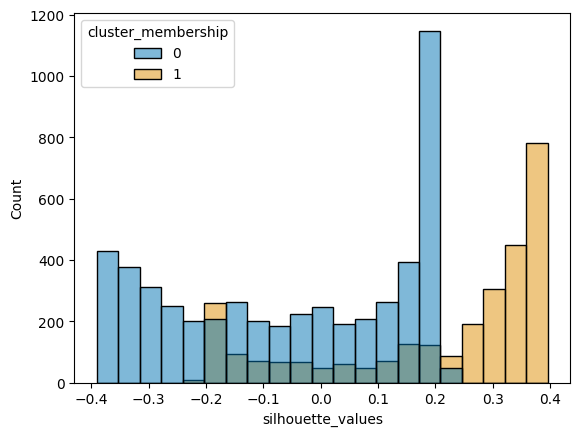

In [77]:
sns.histplot(data=silhouette_df, x='silhouette_values', hue='cluster_membership', palette='colorblind')

In [78]:
score=silhouette_score(distance_matrix, kp.labels_ , metric="precomputed")

# silhouette_scores[k]=score
print("The Silhouette score is: ", score)

The Silhouette score is:  0.041903974132294304


In [102]:
centroid_df = pd.DataFrame(kp.cluster_centroids_, columns = list(X.columns[num_col_indexes])+list(X.columns[cat_col_indexes]))
centroid_df.head()

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,0.077149,0.531915,0.024344,0.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.084679,0.600958,0.004413,0.0,19.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [103]:
centroid_df.loc[:,num_cols] = scaler.inverse_transform(centroid_df[num_cols])

In [105]:
cat_encoders

{'adult': LabelEncoder(),
 'original_language': LabelEncoder(),
 'status': LabelEncoder()}

In [118]:
for col in cat_cols:
    encoder = cat_encoders[col]
    centroid_df[col] = encoder.inverse_transform(centroid_df[col].astype(int))

In [119]:
centroid_df

,runtime,vote_average,vote_count,adult,original_language,status,HU,ta,43,el,...,FR,fr,Horror,Romance,Action,Thriller,Comedy,Drama,US,en
0,97.822581,5.787233,342.637777,0,en,Released,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,0,fr,Released,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Fairly close runtimes and vote averages. Both are not differentiated by being adult nor by status. Original language is a differentiating characteristic now.

In [125]:
criteria = centroid_df.iloc[0,:] != centroid_df.iloc[1,:]

criteria

runtime               True
vote_average          True
vote_count            True
adult                False
original_language     True
                     ...  
Thriller             False
Comedy               False
Drama                 True
US                    True
en                    True
Length: 108, dtype: bool

In [126]:
centroid_df[criteria.index[criteria]]

,runtime,vote_average,vote_count,original_language,Drama,US,en
0,97.822581,5.787233,342.637777,en,0.0,1.0,1.0
1,107.271899,6.408619,62.107919,fr,1.0,0.0,0.0


We can see that the categorical differentiators are wether the genre is Drama, wether it was produced in the US, and whether English is spoken in the movie or not. Common appearance of certain characteristics seems to not have influenced cluster assignment.

## Option 3: Add PCA to Option 2 to reduce dimensionality and sparsity.

The main drawback is that adding PCA to the preprocessing reduces generality inasmuch as the principal components may vary with subsamples of the data and entails a loss of interpretability.

## Option 4: Apply the extended K-Prototypes.